In [1]:
import warnings

# importing functions from my debugging code
from idt.ui import DBG, HLT, NEW, NXT, END, MRK, HLN, CND, ERR, PLT


[+] generating dataset

[*] dataset type = EMLC1

[*] samples = 500


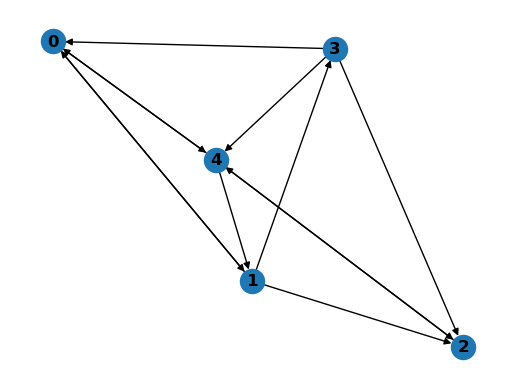

A = [[0 1 0 0 1]
 [1 0 1 1 0]
 [0 0 0 0 1]
 [1 0 1 0 1]
 [1 1 1 0 0]]

A^T = [[0 1 0 1 1]
 [1 0 0 0 1]
 [0 1 0 1 1]
 [0 1 0 0 0]
 [1 0 1 1 0]]

U_0 = [[1.]
 [0.]
 [0.]
 [1.]
 [0.]]

U_1 = [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


[*] folds = 5

[+] STARTING :: gnn.py -> class GNN -> __init__()

[*] convolution layers =  8 x GCNConv(128, 128)

[*] activation = ReLU

[+] STARTING :: gnn.py -> class GNN -> fit()




  | Name        | Type       | Params
-------------------------------------------
0 | embedding   | Linear     | 256   
1 | act         | ReLU       | 0     
2 | norms       | ModuleList | 3.1 K 
3 | conv_layers | ModuleList | 132 K 
4 | out         | Sequential | 16.8 K
5 | loss        | NLLLoss    | 0     
-------------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.609     Total estimated model params size (MB)



[+] STARTING :: idt.py -> class IDT -> fit()

[*] 32 layers computed

[*] out_layer computed

    GCN test accuracy: 0.7400000095367432
    IDT test accuracy: 1.0
    IDT F1 score:      1.0
    Fidelity:          0.74

[+] STARTING :: idt.py -> class IDT -> prune()

[✓] COMPLETED :: idt.py -> class IDT -> prune()


[+] STARTING :: idt.py -> class IDT -> plot()

[+] plotting layer 0

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 1

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 2

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 3
The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node with value=128: go to node 1 if X[:, 1] <= 1.9685604544210062 else to node 4.
	node=1 is a leaf node with value=128.
	node=4 is a split node with value=128: go to node 5 if X[:, 1] <= 3.3829039509328567 else to node 6.
		node=5 is a leaf node with value=128.
		node=6 is a leaf node with value=128.

[✓] successfully plotted lay

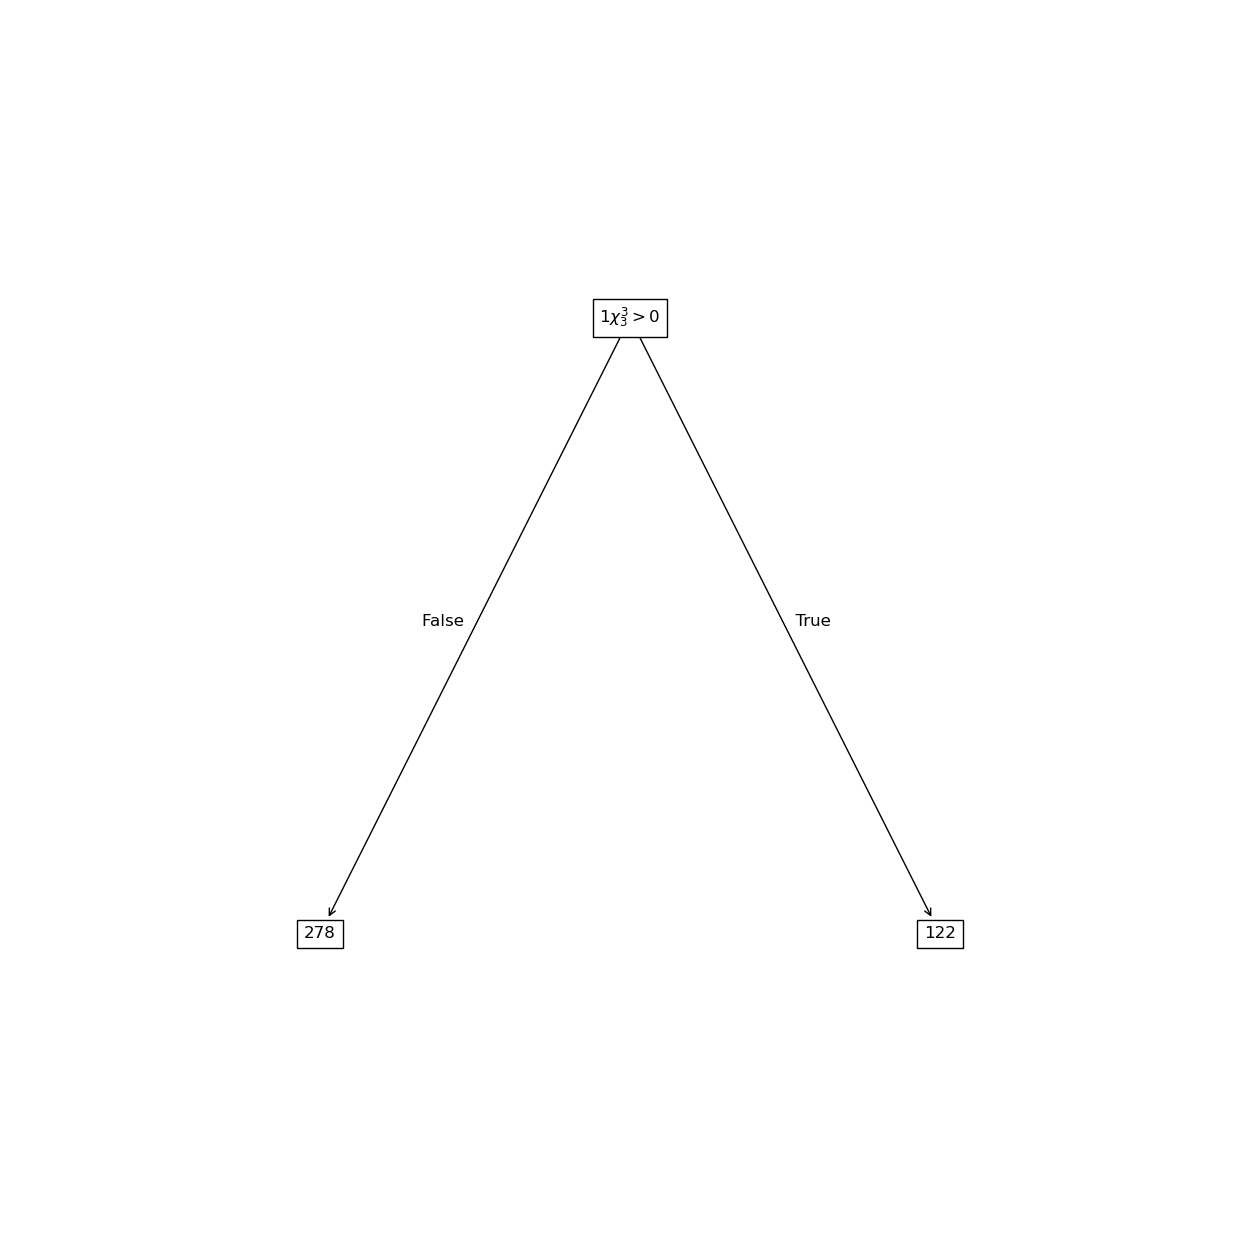

In [2]:
import torch

from idt.data import data

# suppressing some irrelevant warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
import logging
logging.getLogger('lightning').setLevel(0)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
#logger = logging.getLogger('pytorch_lightning.utilities.rank_zero')
#logger.setLevel(logging.ERROR)

num_features, num_classes, train_loader, val_loader, train_val_batch, test_batch = data('EMLC1', 5, 0, seed=42, plot_a_sample=True)
    
bincount = torch.bincount(train_val_batch.y, minlength=2)
weight = len(train_val_batch) / (2 * bincount.float())

# ---

from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from idt.gnn import GNN

torch.set_float32_matmul_precision('high')

GCN = GNN(num_features, num_classes, layers=8, dim=128, activation="ReLU", conv="GCN", pool="mean", lr=1e-4, weight=weight)
early_stop_callback = EarlyStopping(monitor="GCN_val_loss", patience=10, mode="min")

trainer = Trainer(
    max_steps=1000,
    enable_checkpointing=False,
    enable_progress_bar=False,
    log_every_n_steps=1,
    callbacks=[early_stop_callback],
)

NEW("STARTING :: gnn.py -> class GNN -> fit()")
print("")
trainer.fit(GCN, train_dataloaders=train_loader, val_dataloaders=val_loader)
#END("COMPLETED :: gnn.py -> class GNN -> __init__()")

# ---

from idt.idt import IDT, get_activations

idt = IDT(width=4, sample_size=1000, layer_depth=2, max_depth=None, ccp_alpha=1e-3)
values = get_activations(train_val_batch, GCN)
#print(type(train_val_batch))
idt.fit(train_val_batch, values, train_val_batch.y)
print(f"""
    GCN test accuracy: {(GCN(test_batch).argmax(-1) == test_batch.y).float().mean().item()}
    IDT test accuracy: {idt.accuracy(test_batch)}
    IDT F1 score:      {idt.f1_score(test_batch)}
    Fidelity:          {idt.fidelity(test_batch, GCN)}""")

# ---

tree = idt.prune()
idt.plot()

### <font color=DodgerBlue> __Dataset__ </font>

in this example, a directed version of EMLC1 is used:

![EMLC1](emlc1.png)

### <font color=DodgerBlue> __Inner layer__ </font>

layer3 is the only IDTInnerLayer in this run which was not pruned. It learned the rule (there is at least 1 node with at least 3 out_degrees) and outputs a positive detection to node 6 (i.e. leaf node 3). 

![layer3](layer3.png)

[Text(0.4, 0.8333333333333334, 'x[1] <= 1.969\nsquared_error = 0.364\nsamples = 2000\nvalue = [[0.2]\n[1.721]\n[0.378]\n[0.323]\n[1.73]\n[0.524]\n[0.79]\n[0.461]\n[0.057]\n[0.474]\n[1.332]\n[0.224]\n[0.329]\n[0.898]\n[0.22]\n[0.251]\n[0.123]\n[0.501]\n[0.097]\n[0.661]\n[0.254]\n[0.266]\n[0.511]\n[0.431]\n[0.438]\n[0.398]\n[0.335]\n[0.505]\n[0.023]\n[0.191]\n[0.387]\n[0.92]\n[0.059]\n[1.071]\n[1.491]\n[0.658]\n[0.104]\n[1.342]\n[0.103]\n[0.417]\n[0.296]\n[1.476]\n[0.198]\n[0.093]\n[0.095]\n[0.998]\n[0.637]\n[0.0]\n[0.203]\n[0.383]\n[1.076]\n[0.31]\n[0.24]\n[0.206]\n[0.052]\n[1.495]\n[0.348]\n[0.351]\n[0.388]\n[0.211]\n[0.408]\n[0.588]\n[0.62]\n[0.027]\n[1.107]\n[0.806]\n[1.072]\n[0.306]\n[0.106]\n[0.452]\n[0.773]\n[0.366]\n[1.475]\n[0.419]\n[0.896]\n[0.864]\n[0.943]\n[0.439]\n[0.422]\n[1.361]\n[0.468]\n[0.892]\n[0.221]\n[0.091]\n[0.239]\n[0.05]\n[0.273]\n[0.276]\n[0.375]\n[0.852]\n[1.104]\n[0.041]\n[0.002]\n[0.187]\n[0.0]\n[0.6]\n[0.458]\n[1.275]\n[0.214]\n[0.1]\n[0.414]\n[0.581]\n[0.40

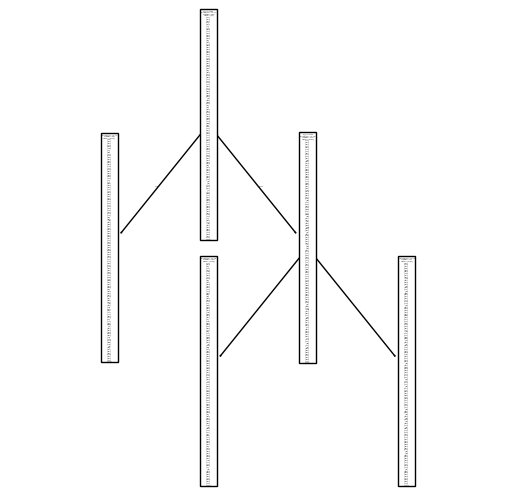

In [10]:
from sklearn.tree import plot_tree

plot_tree(idt.layer[3].dt)

In [21]:
def plot_layer_3(idt, n=0):
    import numpy as np
    from idt.ui import DBG, HLT, NEW, NXT, END, MRK, HLN, CND, ERR, PLT
    n_nodes = idt.layer[3].dt.tree_.node_count
    children_left = idt.layer[3].dt.tree_.children_left
    children_right = idt.layer[3].dt.tree_.children_right
    feature = idt.layer[3].dt.tree_.feature
    threshold = idt.layer[3].dt.tree_.threshold
    values = idt.layer[3].dt.tree_.value
        
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        
        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    prune = True
    prune_nodes = 0
    for i in range(n_nodes):
        if is_leaves[i] == False:
            if threshold[i] != -2:
                prune = False
            else:
                prune_nodes += 1
    if prune == True:    
        NXT("layer pruned")
        return 0
        
    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes-prune_nodes)
    )
    
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with value={value}.".format(
                    space=node_depth[i] * "\t", node=i, value=len(values[i])  #np.around(values[i], 3)
                )
            )
        else:
            if threshold[i] != -2:
                print(
                    "{space}node={node} is a split node with value={value}: "
                    "go to node {left} if X[:, {feature}] <= {threshold} "
                    "else to node {right}.".format(
                        space=node_depth[i] * "\t",
                        node=i,
                        left=children_left[i],
                        feature=feature[i],
                        threshold=threshold[i],
                        right=children_right[i],
                        value=len(values[i])  #np.around(values[i], 3),
                    )
                )

plot_layer_3(idt)

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node with value=128: go to node 1 if X[:, 1] <= 1.9685604544210062 else to node 4.
	node=1 is a leaf node with value=128.
	node=4 is a split node with value=128: go to node 5 if X[:, 1] <= 3.3829039509328567 else to node 6.
		node=5 is a leaf node with value=128.
		node=6 is a leaf node with value=128.


In [17]:
import copy
idt_test = copy.deepcopy(idt)

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node with value=128: go to node 1 if X[:, 1] <= 1.9685604544210062 else to node 4.
	node=1 is a leaf node with value=128.
	node=4 is a split node with value=128: go to node 5 if X[:, 1] <= 3.3829039509328567 else to node 6.
		node=5 is a leaf node with value=128.
		node=6 is a leaf node with value=128.


In [19]:
idt_test.layer[3].dt.tree_.value[3]

#print(str(idt.layer[3].dt.tree_.value))

128

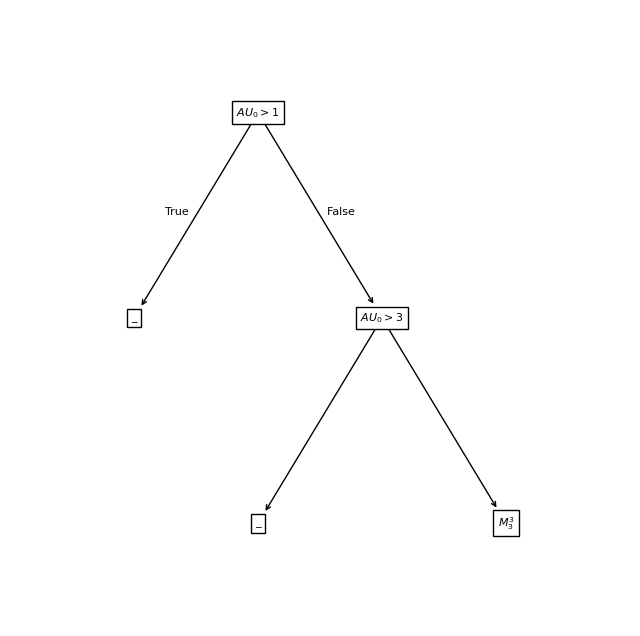

In [77]:
formulas = [r'''$AU_1 \leq 1.969$''', r'''TODO''', r'''null''', r'''null''', r'''$AU_1 \leq 3.383$''', r'''TODO''', r'''TODO''']

#idt_test.layer[3].dt.tree_.value = formulas

#print(len(idt_test.layer[3].dt.tree_.value))

#plot_layer_3(idt_test)

def _feature_depth_index_TEST(index, depth_indices):
    index = index % sum(depth_indices)
    depth = -1
    for i in depth_indices:
        if index < i:
            return depth, index
        index -= i
        depth += 1

def _feature_formula_TEST(index, depth_indices):
    depth, index = _feature_depth_index_TEST(index, depth_indices)
    if depth == -1:
        return fr'U_{{{index}}}'
    else:
        return fr'\chi_{{{index}}}^{{{depth}}}'

def TEST(idt_test, n=3):
    from sklearn.tree import plot_tree
    from sklearn import tree
    from sklearn.tree import DecisionTreeClassifier
    import matplotlib.pyplot as plt
    import matplotlib
    import re
    import numpy as np

    n_nodes = idt_test.layer[3].dt.tree_.node_count
    children_left = idt_test.layer[3].dt.tree_.children_left
    children_right = idt_test.layer[3].dt.tree_.children_right
    feature = idt_test.layer[3].dt.tree_.feature
    threshold = idt_test.layer[3].dt.tree_.threshold
    values = idt_test.layer[3].dt.tree_.value

    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    is_leaves[1] = True
    is_leaves[5] = True
    is_leaves[6] = True
    
    fig, ax = plt.subplots(figsize=(8,8))
    plot_tree(idt_test.layer[3].dt, ax=ax)
    leaf_counter = 0
    for obj in ax.properties()['children']:
        if type(obj) == matplotlib.text.Annotation:
            obj.set_fontsize(8)
            txt = obj.get_text().splitlines()[0]
            match = re.match(r'x\[(\d+)\] <= (\d+\.\d+)', txt)
            skip = False
            if match:
                feature, threshold = match.groups()
                feature = int(feature)
                formula = _feature_formula_TEST(feature, idt_test.layer[3].depth_indices)
                threshold = float(threshold)
                if feature < idt_test.layer[3].n_features_in:
                    obj.set_text(fr'$I{formula} > 0$')
                elif feature < 2 * idt_test.layer[3].n_features_in:
                    obj.set_text(fr'$A{formula} > {int(threshold)}$')
                elif feature < 3 * idt_test.layer[3].n_features_in:
                    obj.set_text(fr'$A^T{formula} > {int(threshold)}$')
                elif feature < 4 * idt_test.layer[3].n_features_in:
                    obj.set_text(fr'$A{formula} > {threshold}$')
                elif feature < 5 * idt_test.layer[3].n_features_in:
                    obj.set_text(fr'$A^T{formula} > {threshold}$')
            else:
                if leaf_counter == 0:
                    obj.set_text(r'''_''')
                elif leaf_counter == 3:
                    obj.set_text(r'''_''')
                elif leaf_counter == 4:
                    obj.set_text(r'''$M_3^3$''')
                leaf_counter += 1
    plt.show()
    plt.close()

TEST(idt_test)

$AU_1 \leq 1.969$

$AU_1 \leq 3.3829039509328567$

In [ ]:

        PLT("plotting out layer")
        self.out_layer.plot(ax, len(self.layer))
        ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]

def plot_outer_TEST(self, n=0):
    from sklearn.tree import plot_tree
    from sklearn import tree
    from sklearn.tree import DecisionTreeClassifier
    import matplotlib.pyplot as plt
    import matplotlib
    import re
    import numpy as np
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_tree(self.dt, ax=ax)
    for obj in ax.properties()['children']:
        if type(obj) == matplotlib.text.Annotation:
            obj.set_fontsize(12)
            txt = obj.get_text().splitlines()[0]
            match = re.match(r'x\[(\d+)\] <= (\d+\.\d+)', txt)
            if match:
                feature, threshold = match.groups()
                feature = int(feature)
                formula = _feature_formula(feature, self.depth_indices)
                threshold = float(threshold)
                if feature < self.n_features_in:
                    obj.set_text(fr'$1{formula} > {threshold}$')
                else:
                    obj.set_text(fr'$1{formula} > {int(threshold)}$')
            if 'True' in txt:
                obj.set_text(txt.replace('True', 'False'))
            elif 'False' in txt:
                obj.set_text(txt.replace('False', 'True'))